Importing libraries

In [1350]:
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

Transferring data from a spreadsheet to a Pandas DataFrame; allows for easier manipulation of data from function to function and allows for better visualization

In [1351]:
stock_data = pd.read_csv("Datasets/final_set.csv")

data = []

for i in stock_data.values:
    if i[8] == "Residential" and i[5] == "British Columbia":
        data.append(i)
df = pd.DataFrame(data)
df.columns = [
    "Municipality",
    "Latitude",
    "Longitude",
    "CGNDB ID",
    "Generic Term",
    "Province - Territory",
    "Nearest NSRDB latitude",
    "Nearest NSRDB longitude",
    "Array Type",
    "Market Pricing",
    "Tariff Applied",
    "First Yr Annual (MWh)",
    "First Yr Winter (MWh)",
    "First Yr Spring (MWh)",
    "First Yr Summer (MWh)",
    "First Yr Fall (MWh)",
    "Installation Cost Scenario",
    "Breakeven Price ($/MWh)",
    "Reference Price ($/MWh)",
    "Breakeven Price (¢/kWh)",
    "Reference Price (¢/kWh)",
    "Total Capacity (MW)",
    "Annual",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]


In [1352]:
print(df)

       Municipality  Latitude  Longitude CGNDB ID           Generic Term  \
0    100 Mile House     51.64    -121.29    JCBMZ  District Municipality   
1    100 Mile House     51.64    -121.29    JCBMZ  District Municipality   
2    108 Mile Ranch     51.75    -121.35    JBHFG              Community   
3    108 Mile Ranch     51.75    -121.35    JBHFG              Community   
4     70 Mile House     51.30    -121.40    JCCIT              Community   
..              ...       ...        ...      ...                    ...   
777            Ymir     49.28    -117.21    JBTAG              Community   
778          Youbou     48.86    -124.20    JBTBI              Community   
779          Youbou     48.86    -124.20    JBTBI              Community   
780        Zeballos     49.98    -126.84    JBTDH                Village   
781        Zeballos     49.98    -126.84    JBTDH                Village   

    Province - Territory  Nearest NSRDB latitude  Nearest NSRDB longitude  \
0       Br

# K = 1-20; 33/66 Split

This model splits the dataset such that one-third is used to fit the model and the rest is used for evaluation. The `GridSearchCV()` function automatically tests and validates a preset range of model parameters; in this instance, when paired with a `KNeighborsRegressor()` model, `GridSearchCV()` performs a search of the best K value for the model between 1 and 20; it additionally finds the best K Fold value for cross validation. This is performed on an initial `train` set and the best parameters, when found, are applied to evaluate the `eval` set.

In [1353]:
df_feats = df[["Latitude", "Longitude", "Total Capacity (MW)", "Annual"]]
df_labels = df[["First Yr Annual (MWh)"]]

In [1354]:
rstate=0


In [1355]:
feats_train, feats_eval, labels_train, labels_eval = train_test_split(df_feats, df_labels, train_size=0.33, random_state=rstate)

In [1356]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 21)}
model_knn = GridSearchCV(model, knn_grid, cv=9)
model_knn.fit(feats_train, labels_train)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Fit: ", model_knn.best_score_, "\n")



Best K Value:  {'n_neighbors': 1}
R^2 - Fit:  0.8520964323676927 



In [1357]:
print(pd.DataFrame(model_knn.cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.001890  3.145842e-04         0.001335    4.720636e-04   
1        0.001446  4.974485e-04         0.001223    4.161415e-04   
2        0.001223  4.160141e-04         0.001446    4.972353e-04   
3        0.001668  4.719136e-04         0.001001    1.633012e-07   
4        0.001112  3.145563e-04         0.001557    4.972235e-04   
5        0.001446  4.973596e-04         0.001334    4.717637e-04   
6        0.001557  4.973123e-04         0.001223    4.160778e-04   
7        0.001335  4.717637e-04         0.001335    4.718199e-04   
8        0.001446  4.974485e-04         0.001446    4.973537e-04   
9        0.001335  4.718949e-04         0.001668    4.717263e-04   
10       0.001223  4.162831e-04         0.001779    4.160565e-04   
11       0.001557  4.973597e-04         0.001446    4.973715e-04   
12       0.001669  4.718575e-04         0.001445    4.972057e-04   
13       0.001223  4.160991e-04         0.001557

In [1358]:
output = model_knn.predict(feats_eval)
print("R^2 - Evaluation: ", model_knn.score(feats_eval, labels_eval))


R^2 - Evaluation:  0.8633657990868748


In [1359]:
labels_eval = pd.DataFrame.to_numpy(labels_eval)

In [1360]:
errors = []

#   mean_absolute_error()
#   mean_absolute_percentage_error()

for i in range(len(output)):
    errors.append(mean_absolute_percentage_error(labels_eval[i], output[i])*100)

errors = pd.DataFrame(errors)

In [1361]:
print(mean_absolute_error(labels_eval, output))

0.09885496183206108


In [1362]:
print(mean_absolute_percentage_error(labels_eval, output))

0.017136439964508143


In [1363]:
print(labels_eval[0])

[6.22]


Mapping points based on percent error

In [1364]:
mapdata = feats_eval

In [1365]:
mapdata.insert(3, "Error", errors)

mapdata = mapdata.sort_values(by=["Error"])

Text(0.5, 1.0, 'Error (percentage)')

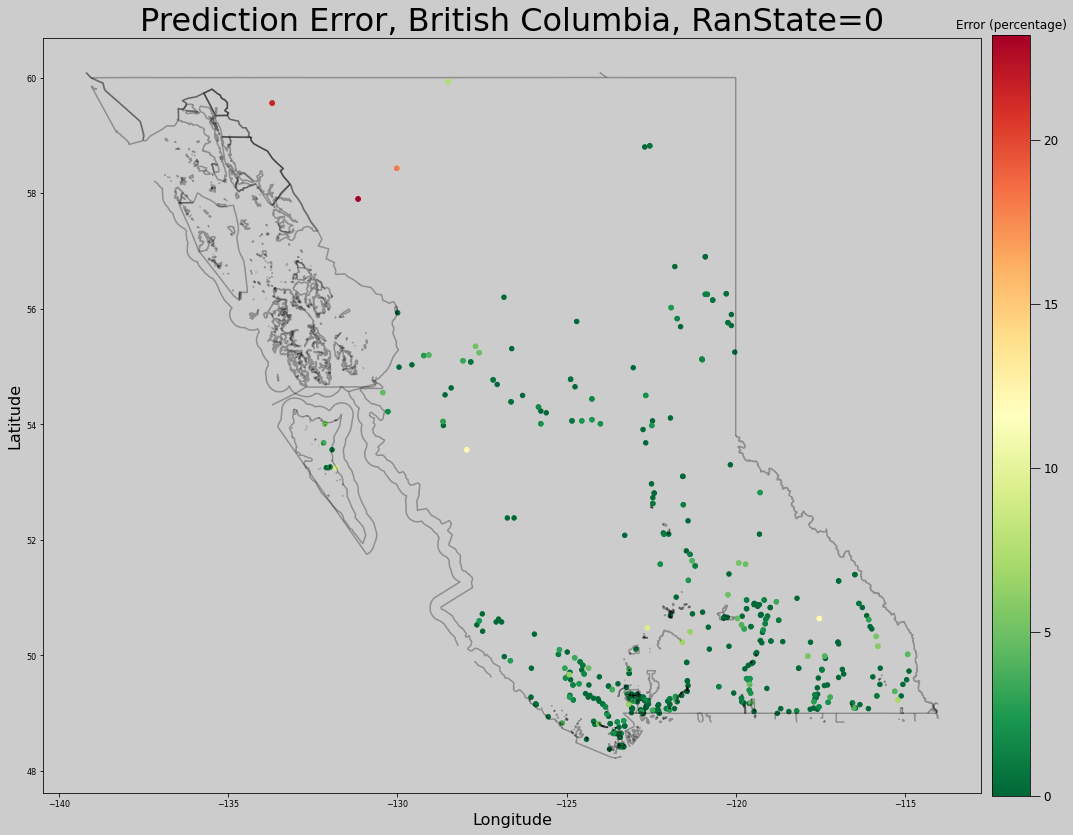

In [1366]:
map = gpd.read_file("Shapefile/british_columbia_administrative.shp")
fig, ax = plt.subplots(figsize=(20, 20))
crs = CRS("EPSG:4326")

geometry = [Point(xy) for xy in (zip(mapdata["Longitude"], mapdata["Latitude"]))]
geoframe = gpd.GeoDataFrame(mapdata, crs=crs, geometry=geometry)

geography = map.plot(ax=ax, alpha=0.3, color="black")
plt.title("Prediction Error, British Columbia, RanState=" + str(rstate), fontsize=32)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
fig.patch.set_facecolor((0.80, 0.80, 0.80))
ax.set_facecolor((0.80, 0.80, 0.80))

#   cmap="RdYlGn_r"
#   color="black"

plotpoints = geoframe.plot(ax=ax, markersize=20, column="Error", legend_kwds={"shrink": 0.7, "pad": 0.01}, legend=True, cmap="RdYlGn_r")

pointfig = plotpoints.figure
pointax = pointfig.axes[1]
pointax.tick_params(labelsize=12, length=10)
pointax.set_title("Error (percentage)")



Text(0.5, 1.0, 'Error % vs. Latitude')

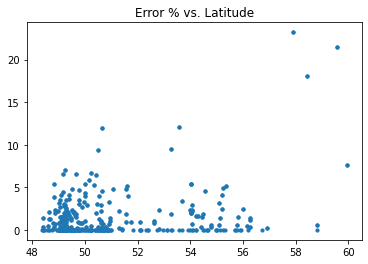

In [1367]:
graph = pd.DataFrame(feats_eval["Latitude"])
graph.insert(1, "Error", errors)
graph = graph.sort_values(by=["Latitude"])

plt.scatter(graph["Latitude"], graph["Error"], s=10)
plt.title("Error % vs. Latitude")

(array([11., 19., 34., 97., 47., 34., 28., 17., 18., 38., 19., 10.,  4.,
        11.,  5.,  0.,  6.,  3.,  5.,  5.,  2.,  6.,  6.,  1., 21.,  6.,
        10.,  7.,  3., 14.,  3.,  4.,  5.,  5.,  6.,  0.,  3.,  0.,  0.,
         0.,  0.,  2.,  0.,  2.,  0.,  3.,  0.,  0.,  2.,  2.]),
 array([48.38 , 48.611, 48.842, 49.073, 49.304, 49.535, 49.766, 49.997,
        50.228, 50.459, 50.69 , 50.921, 51.152, 51.383, 51.614, 51.845,
        52.076, 52.307, 52.538, 52.769, 53.   , 53.231, 53.462, 53.693,
        53.924, 54.155, 54.386, 54.617, 54.848, 55.079, 55.31 , 55.541,
        55.772, 56.003, 56.234, 56.465, 56.696, 56.927, 57.158, 57.389,
        57.62 , 57.851, 58.082, 58.313, 58.544, 58.775, 59.006, 59.237,
        59.468, 59.699, 59.93 ]),
 <BarContainer object of 50 artists>)

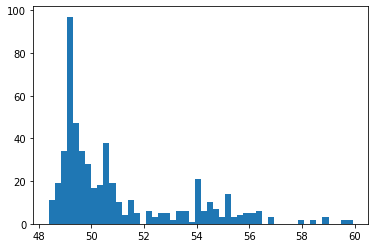

In [1368]:
plt.hist(graph["Latitude"], bins=50)